In [142]:
#QUES 1
# a

import pandas as pd
import numpy as np

df=pd.read_csv("spam.csv",encoding='latin-1')
df=df[['v1','v2']]
df.columns=['label','text']

# Convert labels to numeric
df['label']=df['label'].map({'ham':0, 'spam':1}).astype(int)

df.head()

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_eng=set(stopwords.words("english"))

def clean_text(text):
    text=text.lower()
    text=text.translate(str.maketrans("", "", string.punctuation))
    words=[w for w in text.split() if w not in stopwords_eng]
    return " ".join(words)

df['text']=df['text'].apply(clean_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['label'].values

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42, stratify=y
)

dist = pd.DataFrame({
    "Count": df['label'].value_counts(),
    "Percent %": (df['label'].value_counts(normalize=True)*100).round(2)
})
dist



,Count,Percent %
label,,
0,4825,86.59
1,747,13.41


In [144]:
# b

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump=DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred=stump.predict(X_train)
test_pred=stump.predict(X_test)

print("Train Accuracy:",accuracy_score(y_train, train_pred))
print("Test Accuracy :",accuracy_score(y_test, test_pred))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, test_pred))


Train Accuracy: 0.8837783262284048
Test Accuracy : 0.8923766816143498

Confusion Matrix:
 [[930  36]
 [ 84  65]]


A decision stump splits on only one feature, but TF-IDF creates thousands of features. Spam detection requires combinations of keywords, not just one threshold split (stump is too simple).

In [145]:
# part c

T = 15
n = X_train.shape[0]

w=np.ones(n)/n 

alphas=[]
errors=[]
learners=[]

from sklearn.tree import DecisionTreeClassifier

for t in range(T):
    stump=DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train,y_train,sample_weight=w)

    pred=stump.predict(X_train).astype(int)
    mis=(pred!= y_train).astype(int)

    err=np.dot(w, mis)
    alpha=0.5*np.log((1 - err)/err)

    print(f"\n---- Iteration {t+1} ----")
    bad_idx = np.where(mis == 1)[0]
    print("Misclassified indices:", bad_idx[:20])
    print("Weights of misclassified:", w[bad_idx][:10])
    print("Alpha:", alpha)

    w =w*np.exp(alpha * mis)
    w/= w.sum()

    learners.append(stump)
    alphas.append(alpha)
    errors.append(err)



---- Iteration 1 ----
Misclassified indices: [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196]
Weights of misclassified: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0143534603557114

---- Iteration 2 ----
Misclassified indices: [  9  15  22  31  39  49  59  66  76  88  93 114 115 121 123 159 162 166
 174 194]
Weights of misclassified: [0.00018631 0.00018631 0.00018631 0.00018631 0.00018631 0.00051376
 0.00051376 0.00018631 0.00018631 0.00018631]
Alpha: 0.7967295311027793

---- Iteration 3 ----
Misclassified indices: [ 15  31  39  49  50  59  66  76  86  88  93  96 100 114 115 123 157 159
 162 166]
Weights of misclassified: [0.00034276 0.00034276 0.00034276 0.00094518 0.00042609 0.00094518
 0.00034276 0.00034276 0.00042609 0.00034276]
Alpha: 0.4431708323478377

---- Iteration 4 ----
Misclassified indices: [  9  15  22  31  39  49  50  59  62  66  76  86  88 100 114 115 121 123

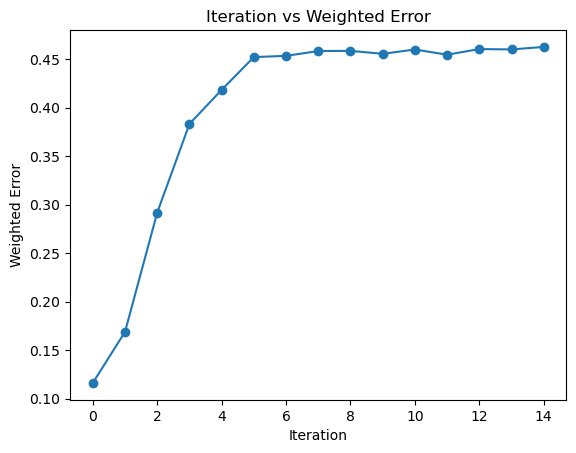

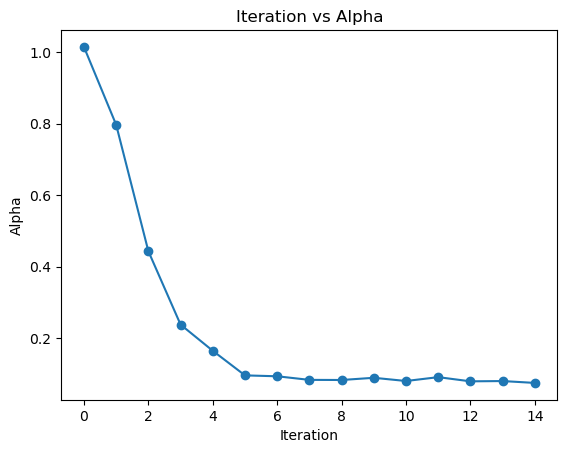

In [146]:
import matplotlib.pyplot as plt

plt.plot(errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

plt.plot(alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()


In [147]:
def ada_predict(X):
    score=np.zeros(X.shape[0])
    for a, clf in zip(alphas, learners):
        score +=a*clf.predict(X).astype(float)
    return (score>= 0.5).astype(int)

train_final=ada_predict(X_train)
test_final=ada_predict(X_test)

print("Train Accuracy:",accuracy_score(y_train, train_final))
print("Test Accuracy :",accuracy_score(y_test, test_final))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, test_final))


Train Accuracy: 0.9066636751177922
Test Accuracy : 0.9112107623318386

Confusion Matrix:
 [[895  71]
 [ 28 121]]


In [148]:
# part d

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

model.fit(X_train, y_train)

p_train = model.predict(X_train)
p_test  = model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, p_train))
print("Test Accuracy :", accuracy_score(y_test, p_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, p_test))



Train Accuracy: 0.9156383217410814
Test Accuracy : 0.9237668161434978

Confusion Matrix:
 [[966   0]
 [ 85  64]]



Sklearn's AdaBoost is more stable with better optimization → higher accuracy than manual version.

QUES 2

In [149]:
#PART A 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Load dataset
data = pd.read_csv("heart_disease_uci.csv")
data['target'] = (data['num'] > 0).astype(int)

bool_cols = ['fbs', 'exang']
for col in bool_cols:
    data[col] = data[col].astype(str).map({'TRUE':1, 'FALSE':0})

# 4) One-hot encode categorical
cat_cols = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
data = data.drop(columns=['id', 'num'])

X = data.drop("target", axis=1)
y = data["target"]

feature_names = list(X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test  = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_pred = stump.predict(X_test)

print("Train Accuracy:", stump.score(X_train,y_train))
print("Test Accuracy :", stump.score(X_test,y_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))


Train Accuracy: 0.6847826086956522
Test Accuracy : 0.7119565217391305

Confusion Matrix:
 [[32 50]
 [ 3 99]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.39      0.55        82
           1       0.66      0.97      0.79       102

    accuracy                           0.71       184
   macro avg       0.79      0.68      0.67       184
weighted avg       0.78      0.71      0.68       184



c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['fbs' 'exang']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['fbs' 'exang']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


A stump cannot capture interactions (cholesterol + age + angina). 



LR=0.1, Estimators=5 ➜ Test Acc=0.7120
LR=0.1, Estimators=10 ➜ Test Acc=0.7772
LR=0.1, Estimators=25 ➜ Test Acc=0.8370
LR=0.1, Estimators=50 ➜ Test Acc=0.8424
LR=0.1, Estimators=100 ➜ Test Acc=0.8533
LR=0.5, Estimators=5 ➜ Test Acc=0.8098
LR=0.5, Estimators=10 ➜ Test Acc=0.8315
LR=0.5, Estimators=25 ➜ Test Acc=0.8424
LR=0.5, Estimators=50 ➜ Test Acc=0.8533
LR=0.5, Estimators=100 ➜ Test Acc=0.8533
LR=1.0, Estimators=5 ➜ Test Acc=0.7935
LR=1.0, Estimators=10 ➜ Test Acc=0.8315
LR=1.0, Estimators=25 ➜ Test Acc=0.8424
LR=1.0, Estimators=50 ➜ Test Acc=0.8587
LR=1.0, Estimators=100 ➜ Test Acc=0.8587


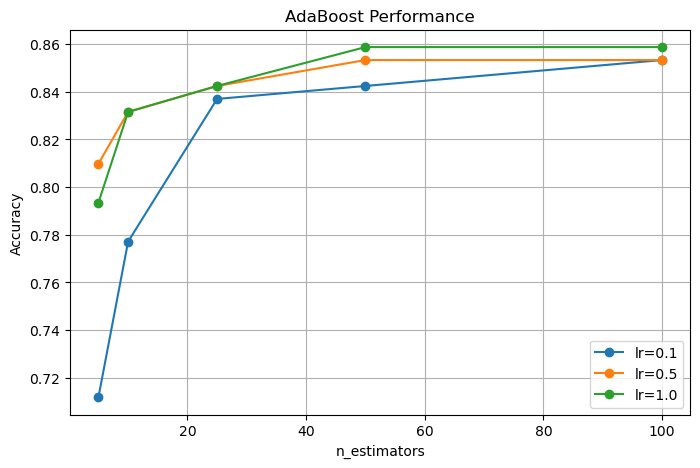


BEST CONFIG → n_estimators=50, learning_rate=1.0, accuracy=0.8587


In [150]:
# PART B 
from sklearn.ensemble import AdaBoostClassifier

estimators = [5,10,25,50,100]
lrs = [0.1,0.5,1.0]
results = {}
for lr in lrs:
    accs = []
    for n in estimators:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        accs.append(acc)
        print(f"LR={lr}, Estimators={n} ➜ Test Acc={acc:.4f}")
    results[lr] = accs

# Plot performance
plt.figure(figsize=(8,5))
for lr in lrs:
    plt.plot(estimators, results[lr], marker='o', label=f"lr={lr}")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost Performance")
plt.grid(True)
plt.show()

# Best combination
best_lr=None
best_n=None
best_acc=0
for lr in lrs:
    for n,acc in zip(estimators, results[lr]):
        if acc>best_acc:
            best_acc=acc
            best_lr=lr
            best_n=n

print(f"\nBEST CONFIG → n_estimators={best_n}, learning_rate={best_lr}, accuracy={best_acc:.4f}")


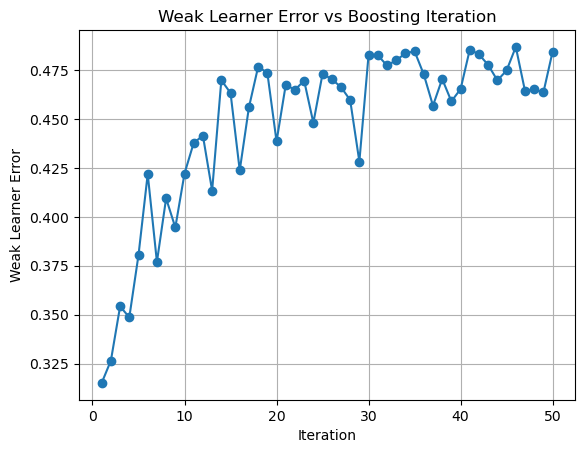

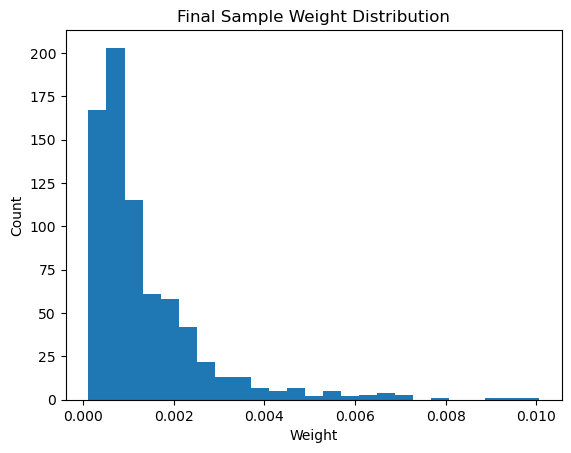

In [ ]:
# PART C 
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

# Train best model using selected hyperparameters
ada_best = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)
ada_best.fit(X_train, y_train)

weak_err = ada_best.estimator_errors_
plt.plot(range(1, len(weak_err)+1), weak_err, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.title("Weak Learner Error vs Boosting Iteration")
plt.grid(True)
plt.show()

# Compute sample weights evolution
weights = np.ones(len(X_train)) / len(X_train)
for i, clf in enumerate(ada_best.estimators_):
    pred = clf.predict(X_train)
    mis = (pred != y_train).astype(int)
    alpha = ada_best.estimator_weights_[i] * best_lr
    weights *= np.exp(alpha * mis)
    weights /= weights.sum()

plt.hist(weights, bins=25)
plt.title("Final Sample Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.show()




c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:273

dataset_Switzerland    0.057609
restecg_normal         0.039674
chol                   0.032609
thalch                 0.030435
oldpeak                0.027717
sex_Male               0.025000
age                    0.024457
slope_flat             0.021196
fbs                    0.020109
exang                  0.017935
dtype: float64


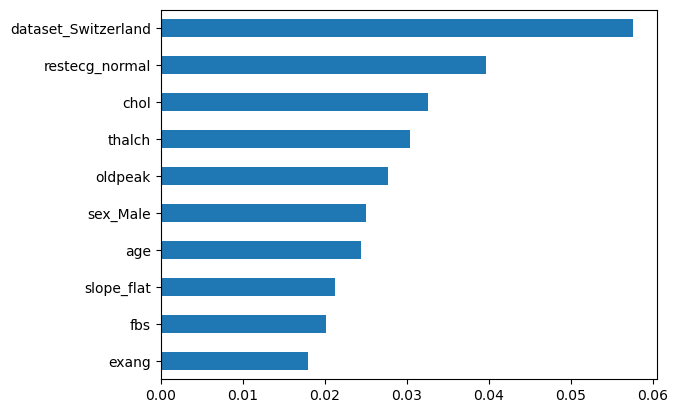

In [ ]:
#part d
from sklearn.inspection import permutation_importance

# Match actual feature count in X_test
real_names = X.columns[:X_test.shape[1]]

X_test_df = pd.DataFrame(X_test, columns=real_names)

result = permutation_importance(
    ada_best,
    X_test_df,
    y_test,
    n_repeats=10,
    random_state=42
)

feat_imp = pd.Series(result.importances_mean, index=real_names)\
          .sort_values(ascending=False)

print(feat_imp.head(10))

feat_imp.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.show()


These features matter medically because they reflect how well the heart receives blood and oxygen.
Chest pain, thallium stress test, and ST-segment depression indicate ischemia or blocked arteries.
The number of affected vessels directly shows the severity of coronary blockage.
Maximum heart rate and ECG slope show how the heart performs under physical stress.
Together, these features give strong clinical signals of heart disease.